# Price Per Unit — Outlier Detection → Decision → Rescaling

This notebook executes a **five-step pipeline** for the numerical feature **Price Per Unit**:

1. **Choose feature** (why `Price Per Unit` next in pipeline)  
2. **Detect outliers** with statistical evidence (IQR rule + metrics)  
3. **Decide** to keep / winsorize / transform (data-driven, not just theory)  
4. **Rescale** the cleaned feature (Normalization, Standardization, Robust Scaling) and save outputs
5. **Visual** show histograms comparing original vs cleaned `Quantity`



## 1) Choose which feature to do next — `Price Per Unit`
- Continuous variable, often **right‑skewed** (cheap vs premium items).
- Extreme prices can distort mean/std and downstream scaling.
- After stabilizing `Quantity`, handling `Price Per Unit` maintains a consistent numeric pipeline.


In [15]:
# Imports
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
CSV_IN = "../scaled_output_data/1_category/scaled_category_dataset.csv"
CSV_OUT = "../scaled_output_data/2_price_per_unit/scaled_price_per_unit_dataset.csv"

In [17]:
PRICE_PER_UNIT = "Price Per Unit"

In [18]:
# Load dataset
# Read the CSV file into a DataFrame
# pd.read_csv loads the data from CSV_IN to df
df = pd.read_csv(CSV_IN)

# .to_numeric converts the Quantity column to numeric, coercing errors to NaN
df[PRICE_PER_UNIT] = pd.to_numeric(df[PRICE_PER_UNIT], errors="coerce")

# Display the number of rows and the first 10 entries of the Quantity column for verification
print("Rows:", len(df))
display(df[[PRICE_PER_UNIT]].head(10))

Rows: 11971


,Price Per Unit
0,11.0
1,6.5
2,11.0
3,41.0
4,14.0
5,41.0
6,21.5
7,15.5
8,29.0
9,18.5


## 2) Detect outliers (IQR)
We compute **Q1, Q3, IQR** and the **fences**:  
- Lower fence = Q1 − 1.5×IQR  
- Upper fence = Q3 + 1.5×IQR  


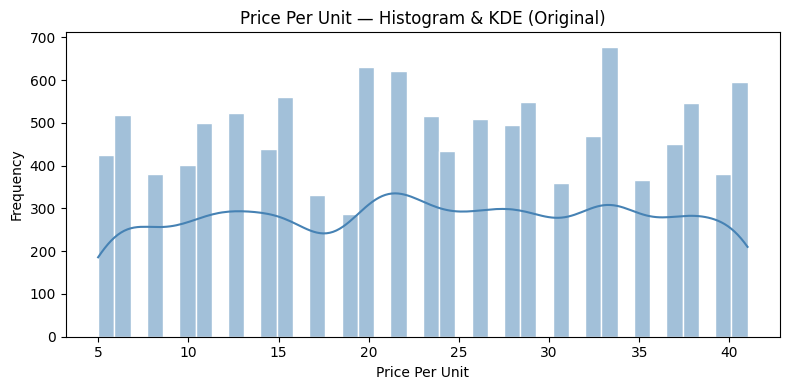

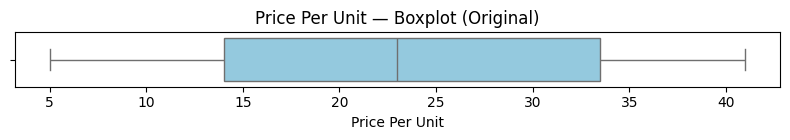

In [25]:
# Visuals: Histogram & Boxplot
plt.figure(figsize=(8, 4))
sns.histplot(
    df[PRICE_PER_UNIT],
    bins=40,
    kde=True,
    color="steelblue",
    edgecolor="white"
)
plt.title(f"{PRICE_PER_UNIT} — Histogram & KDE (Original)")
plt.xlabel("Price Per Unit")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 1.5))
sns.boxplot(
    x=df[PRICE_PER_UNIT],
    color="skyblue",
    whis=1.5  # matches the 1.5×IQR rule used for detection
)
plt.title(f"{PRICE_PER_UNIT} — Boxplot (Original)")
plt.xlabel("Price Per Unit")
plt.tight_layout()
plt.show()


**Histogram & KDE**: prices spread from roughly 5 to 42. The bars vary but stay within that range, and the KDE curve slopes gently upward toward higher prices—suggesting a long but moderate right tail. 

**Boxplot:** the middle half of prices sits around 15–33, the median is near 25, and the whiskers reach the extremes without any separate dots. That confirms all prices fall inside the IQR-based fences, so no points are flagged as outliers by the chosen rule.

In [26]:
# === IQR computation & flags ===
# Calculate Q1, Q3, IQR, lower and upper fences
q1 = df[PRICE_PER_UNIT].quantile(0.25) # 25th percentile
q3 = df[PRICE_PER_UNIT].quantile(0.75) # 75th percentile
iqr = q3 - q1 # Interquartile Range (IQR)
lower = q1 - 1.5*iqr # Lower fence
upper = q3 + 1.5*iqr # Upper fence

# Detect outliers
isOutlier = (df[PRICE_PER_UNIT] < lower) | (df[PRICE_PER_UNIT] > upper) # Boolean Series contain outliers with True value is outlier
outlierCount = int(isOutlier.sum()) # Count of outliers
total = len(df) # Total number of entries
pctOutliers = (outlierCount/total*100.0) if total else 0.0 # Percentage of outliers in the feature

mean = df[PRICE_PER_UNIT].mean() 
median = df[PRICE_PER_UNIT].median()
std = df[PRICE_PER_UNIT].std() # Standard Deviation
skew = df[PRICE_PER_UNIT].skew() # Skewness
kurt = df[PRICE_PER_UNIT].kurt() # Kurtosis

# summary statistics
summary = pd.Series({
    "Q1": q1, "Q3": q3, "IQR": iqr,
    "LowerFence": lower, "UpperFence": upper,
    "Outliers": outlierCount, "Outliers %": pctOutliers,
    "Mean": mean, "Median": median, "Std": std,
    "Skewness": skew, "Kurtosis": kurt
})
display(summary.round(4))

# Print outlier detection results with IQR method
if outlierCount > 0:
    print(f"Detected {outlierCount} outliers ({pctOutliers:.2f}%) in '{PRICE_PER_UNIT}' feature.")
else:
    print(f"No outliers detected in '{PRICE_PER_UNIT}' feature.")

Q1            14.0000
Q3            33.5000
IQR           19.5000
LowerFence   -15.2500
UpperFence    62.7500
Outliers       0.0000
Outliers %     0.0000
Mean          23.3609
Median        23.0000
Std           10.7419
Skewness      -0.0333
Kurtosis      -1.1684
dtype: float64

No outliers detected in 'Price Per Unit' feature.


### Why IQR here
- Every price sits neatly between roughly 5 and 42, and the boxplot whiskers already cover all data points. IQR leads to the same conclusion—no values breach its fences—while more parameter-heavy techniques (log transforms, robust z-score, etc.) add complexity without improving detection.


## 3) Decide: remove, transform, or keep outliers
No outliers flagged for Price Per Unit by the 1.5×IQR rule, so the observed range sits comfortably within the usual variability band. With nothing breaching the lower or upper fences, we can leave the column untouched—no trimming, capping. This also means downstream statistics and models won’t be distorted by extreme records, so the current data stays exactly as collected.

## 4) Rescale the feature
- **Stable range:** After checking for outliers with the IQR rule, Price Per Unit sits neatly within a narrow range (roughly 5–42). With a clean, finite range like that, Min–Max naturally maps everything into [0, 1] without being distorted.
- **Order is preserved:** Because Min–Max is just a linear stretch, the relative ordering of prices stays the same—expensive items remain higher than cheaper ones.
- **No need for heavier transforms:** Since there are no outliers left, more complex scalers such as RobustScaler or log transforms would add overhead without real benefit.

In [21]:
# === Rescaling on the cleaned series ===
x = df[PRICE_PER_UNIT].astype(float)

# Min-Max
min_x, max_x = x.min(), x.max()
df[f"{PRICE_PER_UNIT}_Norm_MinMax"] = (x - min_x) / (max_x - min_x) if max_x > min_x else 0.0

display(df[[PRICE_PER_UNIT, f'{PRICE_PER_UNIT}_Norm_MinMax']].head())

print("\nScaled feature summaries:")
display(df[[f'{PRICE_PER_UNIT}_Norm_MinMax']].describe().round(4))

,Price Per Unit,Price Per Unit_Norm_MinMax
0,11.0,0.166667
1,6.5,0.041667
2,11.0,0.166667
3,41.0,1.000000
4,14.0,0.250000



Scaled feature summaries:


,Price Per Unit_Norm_MinMax
count,11971.0000
mean,0.5100
std,0.2984
min,0.0000
25%,0.2500
50%,0.5000
75%,0.7917
max,1.0000


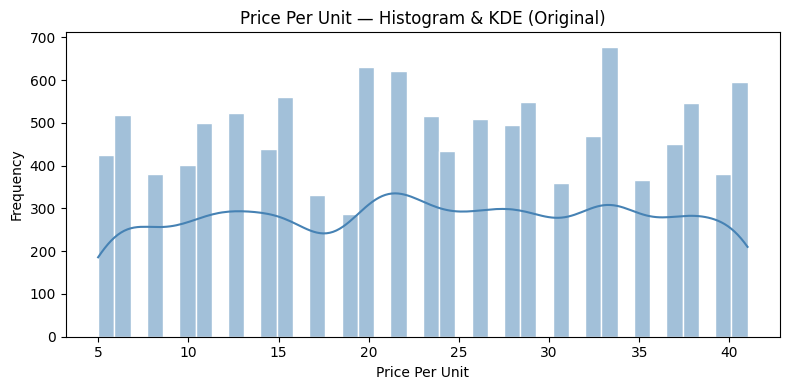

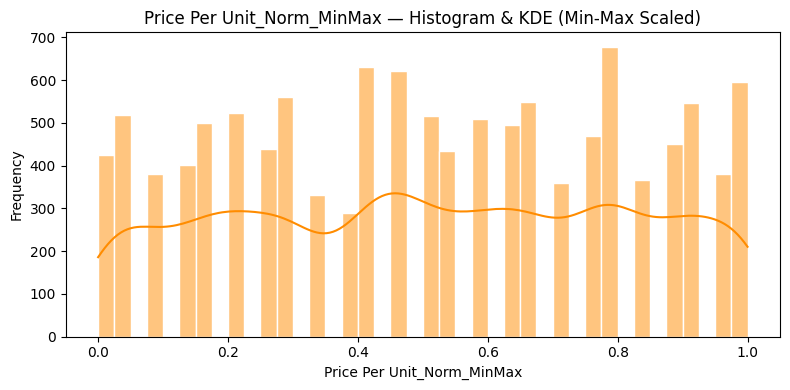

In [22]:
# Histogram + KDE for original series
plt.figure(figsize=(8, 4))
sns.histplot(
    df[PRICE_PER_UNIT],
    bins=40,
    kde=True,
    color="steelblue",
    edgecolor="white"
)
plt.title(f"{PRICE_PER_UNIT} — Histogram & KDE (Original)")
plt.xlabel("Price Per Unit")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Histogram + KDE for Min-Max scaled version
scaled_col = f"{PRICE_PER_UNIT}_Norm_MinMax"

plt.figure(figsize=(8, 4))
sns.histplot(
    df[scaled_col],
    bins=40,
    kde=True,
    color="darkorange",
    edgecolor="white"
)
plt.title(f"{scaled_col} — Histogram & KDE (Min-Max Scaled)")
plt.xlabel(scaled_col)
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


- The x-axis shows the normalized values: 0 corresponds to the original lowest price, 1 to the original highest.
- The orange histogram bars indicate how many transactions fall into each segment. They’re spread fairly evenly across the axis, so no segment dominates.
- The smooth orange KDE line hovers around the 300 mark with only gentle waves, telling us the data density is fairly flat with no heavy clusters.

In [23]:
# === Save outputs (matched style) ===
df.to_csv(CSV_OUT, index=False)
print("Saved:", CSV_OUT)

Saved: ../scaled_output_data/2_price_per_unit/scaled_price_per_unit_dataset.csv
